# Updated HDP HMM Evaluation Pipeline

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch
import numpy as np
from sklearn.model_selection import train_test_split

import logging

# Configure logging
logging.basicConfig(
    filename="hdp_training.log",  # output file name
    filemode="a",                 # append mode ("w" for overwrite)
    format="%(asctime)s - %(message)s",
    level=logging.INFO
)


def train_hdp(
    num_states,
    group_data,
    obs_dim,
    test_data=None,
    num_steps=3000,
    patience=500,
    min_delta=1e-3,
    verbose=True
):
    pyro.clear_param_store()

    elbo_trace = []
    best_loss = float("inf")
    patience_counter = 0

    def model(groups):
        gamma = torch.tensor(1.0)
        beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
        beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

        mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
        sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

        for g, seq in enumerate(groups):
            alpha = torch.tensor(1.0)
            pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))
            with pyro.plate(f"obs_{g}", seq.shape[0]):
                z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
                pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

    def guide(groups):
        beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
        pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

        mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
        mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

        sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

        for g in range(len(groups)):
            beta_k_q = pyro.param("beta_k_q")
            pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
            pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

    svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(num_steps):
        loss = svi.step(group_data)
        elbo_trace.append(loss)

        if verbose and step % 100 == 0:
            print(f"[{step}] Loss: {loss:.2f} (ELBO: {-loss:.2f})")

        if loss + min_delta < best_loss:
            if step != 0 and loss == best_loss:
                # Avoid logging same loss repeatedly
                continue
            best_loss = loss
            patience_counter = 0
            msg = f"New best loss at step {step}: {loss}"
            print(msg)
            logging.info(msg)
        else:
            patience_counter += 1
            msg = f"No improvement at step {step} (current loss: {loss}, best: {best_loss}) [patience={patience_counter}]"
            #print(msg)
            logging.info(msg)




        if patience_counter >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            break

    # --- Count active states ---
    beta_k_q = pyro.param("beta_k_q")
    pi_values = []
    
    for g in range(len(group_data)):
        pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
        pi = dist.Dirichlet(pi_alpha).mean  # Use the mean of the variational Dirichlet
        pi_values.append(pi)

    avg_pi = torch.stack(pi_values).mean(dim=0)
    active_states = (avg_pi > 0.01).sum().item()

    # --- Predictive log-likelihood (if test set provided) ---
    predictive_ll = None
    if test_data is not None:
        with torch.no_grad():
            mus = pyro.param("mus_loc")
            sigmas = pyro.param("sigmas_scale")
            test_lls = []
            for seq in test_data:
                log_probs = dist.Normal(mus, sigmas).log_prob(seq.unsqueeze(1))  # [T, K, D]
                test_lls.append(log_probs.sum(-1).logsumexp(dim=1).mean().item())
            predictive_ll = np.mean(test_lls)

    return {
        "elbo_trace": elbo_trace,
        "best_elbo": -best_loss,  # Use negative best loss as final ELBO
        "active_states": active_states,
        "predictive_loglik": predictive_ll
    }


import matplotlib.pyplot as plt

# Split your group data into training and testing groups (if needed)
train_groups, test_groups = train_test_split(group_data, test_size=0.2, random_state=42)

candidate_states = list(range(5,150, 10))  # Finer granularity around promising range
results = []

for k in candidate_states:
    print(f"\nTraining with {k} states...")
    result = train_hdp(k, train_groups, obs_dim=obs_dim, test_data=test_groups)
    results.append((k, result))

# --- Plot Final ELBO and Active States ---
elbos = [r["best_elbo"] for _, r in results]
actives = [r["active_states"] for _, r in results]
predictive_ll = [r["predictive_loglik"] for _, r in results]
state_counts = [k for k, _ in results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(state_counts, elbos, marker='o')
plt.xlabel("Number of States")
plt.ylabel("Final ELBO")
plt.title("Final ELBO vs. State Count")

plt.subplot(1, 2, 2)
plt.plot(state_counts, actives, marker='s', label="Active States")
plt.plot(state_counts, predictive_ll, marker='^', label="Predictive Log-Likelihood")
plt.xlabel("Number of States")
plt.title("Model Diagnostics")
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
max(elbos)

-322678.6319885254

# Pyro HDP-HSMM-Like Code

In [85]:
# get list of ground truth coins
import pandas as pd
path = "../Stempelliste_bueschel_Neuses_einfach.xlsx"
df = pd.read_excel(path, engine='openpyxl')

averse = defaultdict(list)
reverse = defaultdict(list)

ID = df["Dédalo ID"]
A = df["Stempeluntergruppe Av"]
R = df["Stempeluntergruppe Rv"]

for id_val, av, rv in zip(ID, A, R):
    averse[av].append(id_val)
    reverse[rv].append(id_val)
    
averse = {str(k): v for k, v in averse.items()}
truth_coins = list(ID)

# Redo HDP for certain dies

In [102]:
print(df)

    group  die_index                                         image_path
187     C          0  ../bueschelquinare_preprocessed/obverse/C/3898...
34      A          0  ../bueschelquinare_preprocessed/obverse/A/3838...
144     A          0  ../bueschelquinare_preprocessed/obverse/A/3623...
36      A          0  ../bueschelquinare_preprocessed/obverse/A/3773...
86      A          0  ../bueschelquinare_preprocessed/obverse/A/3613...
..    ...        ...                                                ...
53      A         24  ../bueschelquinare_preprocessed/obverse/A/3835...
52      A         24  ../bueschelquinare_preprocessed/obverse/A/3784...
177     A         24  ../bueschelquinare_preprocessed/obverse/A/3689...
190     C         24  ../bueschelquinare_preprocessed/obverse/C/3899...
0       A         24  ../bueschelquinare_preprocessed/obverse/A/3681...

[223 rows x 3 columns]


/home/tim/miniforge3/envs/data_Challenges/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_7972/748643897.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1746251340001/work/torch/csrc/utils/tensor_new.cpp:254.)
  group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]


Loaded 10 groups with 60000 total coins.


/home/tim/miniforge3/envs/data_Challenges/lib/python3.12/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_k'}
  warnings.warn(


[0] ELBO: 1097153206537.91
[50] ELBO: 1782235957.96
[100] ELBO: 2639111983.55
[150] ELBO: 1733417085.05
[200] ELBO: 8896041980.50
[250] ELBO: 3915424756.33
[300] ELBO: 1453747962.74
[350] ELBO: 832686928.61
[400] ELBO: 1328127578.95
[450] ELBO: 2337183274.92
[500] ELBO: 21882328031.49
[550] ELBO: 330569587.51
[600] ELBO: 14089151404.11
[650] ELBO: 1512634938.14
[700] ELBO: 787026597.58
[750] ELBO: 2331821748.84
[800] ELBO: 602702807.10
[850] ELBO: 541723275395.05
[900] ELBO: 2021806123.89
[950] ELBO: 1156529075.22
[1000] ELBO: 846328501.95
[1050] ELBO: 8598887895.99
[1100] ELBO: 939380550145688.12


/tmp/ipykernel_7972/748643897.py:207: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(group_data))


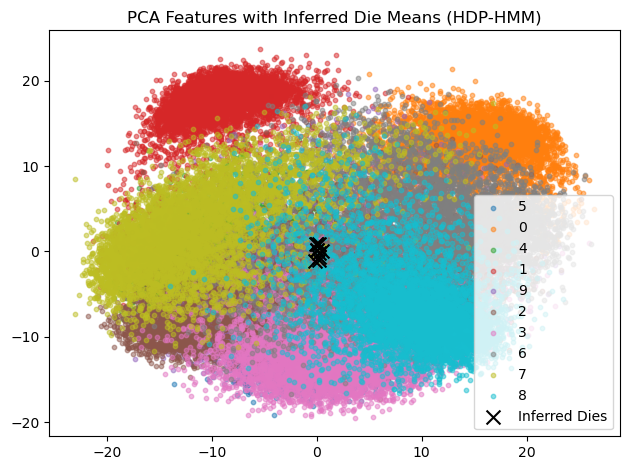

'\nwith torch.no_grad():\n    beta_vals = pyro.get_param_store()["a"] / (pyro.get_param_store()["a"] + pyro.get_param_store()["b"])\n    stick_weights = beta_vals.clone()\n    remaining_stick = torch.cumprod(1 - beta_vals, dim=-1)\n    stick_weights[1:] = beta_vals[1:] * remaining_stick[:-1]\n\n    plt.bar(range(len(stick_weights)), stick_weights.detach().cpu())\n    plt.title("Learned Stick-Breaking Weights (beta_k)")\n    plt.xlabel("Die Index")\n    plt.ylabel("Weight")\n    plt.show()\n'

In [1]:
import pickle
import torch
from collections import defaultdict
import pyro
import pandas as pd
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import pyro.poutine as poutine
# HDP-HMM over groups (each group emits all its coins from a single die)



# Setup
pyro.clear_param_store()
torch.manual_seed(0)
device = torch.device("cpu")

# Load saved features
#with open("coin_features_pca_coin_clip.pkl", "rb") as f:
#    data = pickle.load(f)

with open("features_pca_numbers_clip.pkl", "rb") as f:
       data = pickle.load(f)


# filter for ground truth coins
import numpy as np
# Get the indices of rows to keep
'''
keep_indices = [
    i for i, path in enumerate(data["paths"])
    if int(path.split("/")[-1].split("_")[0]) in truth_coins
]
#Filter all fields in the dict using these indices
filtered_data = {
    "features": data["features"][keep_indices],
    "labels": [data["labels"][i] for i in keep_indices],
    "paths": [data["paths"][i] for i in keep_indices],
    "group_names": data["group_names"],
}
data = filtered_data

Select_Die = True
if Select_Die:
    path = "Numbers_assignment.csv"
    df = pd.read_csv(path)
    die = 5
    Die_Specific = df[df["die_index"] == die]["image_path"].tolist()
   
    keep_indices = [
    i for i, path in enumerate(data["paths"])
    if path in Die_Specific
    ]
    
    filtered_data = {
        "features": data["features"][keep_indices],
        "labels": [data["labels"][i] for i in keep_indices],
        "paths": [data["paths"][i] for i in keep_indices],
        "group_names": data["group_names"],
    }
    data = filtered_data

'''
features = data["features"]
labels = data["labels"]
obs_dim = features.shape[1]


# Group features by label
grouped_features = defaultdict(list)
for feat, label in zip(features, labels):
    grouped_features[label].append(feat)

# Convert to torch tensors
group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
group_names = list(grouped_features.keys())

print(f"Loaded {len(group_data)} groups with {sum(len(g) for g in group_data)} total coins.")

# Ensure all are float32



# Hyperparameters
alpha_val = 50
gamma_val = 1.0
num_states = 10
#num_states = 82
#num_states = 26
obs_dim = group_data[0].shape[1] # dimensionality of feature vectors

# Example group data with 3 groups and 5-dimensional features (dummy structure)
#group_data = [torch.randn(100, obs_dim), torch.randn(120, obs_dim), torch.randn(80, obs_dim)]

def model(groups):
    gamma = torch.tensor(gamma_val)
    
    v_k = pyro.sample("v_k", dist.Kumaraswamy(torch.ones(num_states), torch.ones(num_states)).to_event(1))

    remaining_stick = torch.cumprod(1 - v_k, dim=-1)
    beta_k = v_k.clone()
    beta_k[1:] = v_k[1:] * remaining_stick[:-1]
    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)
    '''
    beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)
    '''
    mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

    # Transition matrix between states (dies)
    with pyro.plate("states", num_states):
        A = pyro.sample("A", dist.Dirichlet(alpha_val * beta[:-1]))

    z_prev = pyro.sample("z_0", dist.Categorical(beta[:-1]))

    for g, group in enumerate(groups):
        if g > 0:
            z_prev = pyro.sample(f"z_{g}", dist.Categorical(A[z_prev]))

        pi_g = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha_val * beta[:-1]))

        with pyro.plate(f"obs_{g}", group.shape[0]):
            z_ng = pyro.sample(f"z_ng_{g}", dist.Categorical(pi_g))
            pyro.sample(f"x_{g}", dist.Normal(mus[z_ng], sigmas[z_ng]).to_event(1), obs=group)

def guide(groups):
    
    #Using Stick breaking Process
    a = pyro.param("a", lambda: torch.ones(num_states) * 2.0, constraint=dist.constraints.greater_than(1e-2))
    b = pyro.param("b", lambda: torch.ones(num_states) * 2.0, constraint=dist.constraints.greater_than(1e-2))
    v_k = pyro.sample("v_k", dist.Kumaraswamy(a, b).to_event(1))
        
    # Construct beta stick-breaking weights from v_k
    # NOTE: We need to handle beta vector properly outside the sample statement.
    remaining_stick = torch.cumprod(1 - v_k, dim=-1)
    beta_k = v_k.clone()
    beta_k[1:] = v_k[1:] * remaining_stick[:-1]
    pyro.deterministic("beta_k", beta_k)
    '''
    beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
    pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))
    '''
    #beta_k_q = pyro.param(
    #    "beta_k_q",
    #    lambda: torch.full((num_states,), 0.8),
    #    constraint=dist.constraints.unit_interval
    #)
    #pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

    mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
    mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

    sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

    init_transition = torch.eye(num_states) * 2 + 1
    A_q = pyro.param("A_q", lambda: init_transition / init_transition.sum(dim=1, keepdim=True),
                 constraint=dist.constraints.simplex)
    with pyro.plate("states", num_states):
        pyro.sample("A", dist.Delta(A_q).to_event(1))


    z0_q = pyro.param("z0_q", lambda: torch.ones(num_states), constraint=dist.constraints.simplex)
    pyro.sample("z_0", dist.Categorical(z0_q))

    for g, group in enumerate(groups):
        pi_q = pyro.param(f"pi_q_{g}", lambda: torch.ones(num_states), constraint=dist.constraints.simplex)
        pyro.sample(f"pi_{g}", dist.Delta(pi_q).to_event(1))
    
        if g > 0:
            z_q = pyro.param(f"z_{g}_q", lambda: torch.ones(num_states), constraint=dist.constraints.simplex)
            #z_q = pyro.param(
            #    f"z_q_{g}",
            #    lambda: torch.ones(group.shape[0], num_states) * (1.0 / num_states),
            #    constraint=dist.constraints.simplex
            #)
            pyro.sample(f"z_{g}", dist.Categorical(z_q))
    
        with pyro.plate(f"obs_{g}", group.shape[0]):
            z_q_ng = pyro.param(f"z_q_{g}", lambda: torch.ones(group.shape[0], num_states), constraint=dist.constraints.simplex)
            #z_q_ng = pyro.param(
            #    f"z_q_{g}",
            #    lambda: torch.ones(group.shape[0], num_states) * (1.0 / num_states),
            #    constraint=dist.constraints.simplex
            #)
            pyro.sample(f"z_ng_{g}", dist.Categorical(z_q_ng))


# Just compile the model and guide (you should call this from your training loop)
svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

# Train
num_steps = 1101
for step in range(num_steps):
    loss = svi.step(group_data)
    if step % 50 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")



# Inferred die (state) locations
mus_post = pyro.param("mus_loc").detach().cpu()
colors = plt.cm.get_cmap('tab10', len(group_data))

# Plot group PCA features
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, alpha=0.5, s=10, color=colors(i))

# Plot inferred die means
plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
plt.title("PCA Features with Inferred Die Means (HDP-HMM)")
plt.legend()
plt.tight_layout()
plt.show()
'''
with torch.no_grad():
    beta_vals = pyro.get_param_store()["a"] / (pyro.get_param_store()["a"] + pyro.get_param_store()["b"])
    stick_weights = beta_vals.clone()
    remaining_stick = torch.cumprod(1 - beta_vals, dim=-1)
    stick_weights[1:] = beta_vals[1:] * remaining_stick[:-1]

    plt.bar(range(len(stick_weights)), stick_weights.detach().cpu())
    plt.title("Learned Stick-Breaking Weights (beta_k)")
    plt.xlabel("Die Index")
    plt.ylabel("Weight")
    plt.show()
'''

In [11]:
print(pyro.get_param_store().keys())

dict_keys(['a', 'b', 'mus_loc', 'mus_scale', 'sigmas_scale', 'A_q', 'z0_q', 'pi_q_0', 'z_q_0', 'pi_q_1', 'z_1_q', 'z_q_1', 'pi_q_2', 'z_2_q', 'z_q_2', 'pi_q_3', 'z_3_q', 'z_q_3', 'pi_q_4', 'z_4_q', 'z_q_4', 'pi_q_5', 'z_5_q', 'z_q_5', 'pi_q_6', 'z_6_q', 'z_q_6', 'pi_q_7', 'z_7_q', 'z_q_7', 'pi_q_8', 'z_8_q', 'z_q_8', 'pi_q_9', 'z_9_q', 'z_q_9'])


In [13]:
# Step 1: Extract posterior parameters
mus = pyro.param("mus_loc").detach()
sigmas = pyro.param("sigmas_scale").detach()
#beta_k_q = pyro.param("beta_k_q").detach()

a = pyro.param("a").detach()
b = pyro.param("b").detach()
beta_k_q = a / (a + b)

beta = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])  # [num_states + 1]

# Load paths
#image_paths = data["paths"]
image_paths = data["labels"]

# Assign image path to die
coin_to_die = []  # updated
idx = 0  # global index across all groups

for g, group in enumerate(group_data):
    pi_alpha = alpha_val * beta[:-1]
    pi_g = dist.Dirichlet(pi_alpha).mean

    log_probs = dist.Normal(mus, sigmas).log_prob(group.unsqueeze(1)).sum(-1) + pi_g.log()
    z_hat = log_probs.argmax(dim=1)

    for z in z_hat:
        coin_to_die.append({
            "group": group_names[g],
            "die_index": z.item(),
            "image_path": image_paths[idx]
        })
        idx += 1

# Now coin_to_die contains (group_name, coin_index, die_index)


In [14]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(coin_to_die)

# Save to CSV
output_csv = "numbers_assignment.csv"
df.to_csv(output_csv, index=False)

print(f"Saved coin-to-die assignments to: {output_csv}")


Saved coin-to-die assignments to: numbers_assignment.csv


In [15]:
from collections import Counter
#path = "coin_to_die_reverse_2200Dies.csv"
#df = pd.read_csv(path)
#coin_to_die = df
# Count how often each die is used
if isinstance(coin_to_die, list):
    die_counts = Counter(entry["die_index"] for entry in coin_to_die)
else:
    die_counts = Counter(coin_to_die["die_index"])

# Print top 10 most used dies
print("Top used dies:")
for die, count in die_counts.most_common(10):
    print(f"Die {die}: {count} coins")


Top used dies:
Die 9: 22665 coins
Die 3: 11658 coins
Die 0: 6746 coins
Die 4: 5737 coins
Die 7: 5674 coins
Die 8: 3495 coins
Die 2: 1777 coins
Die 5: 1197 coins
Die 1: 530 coins
Die 6: 521 coins


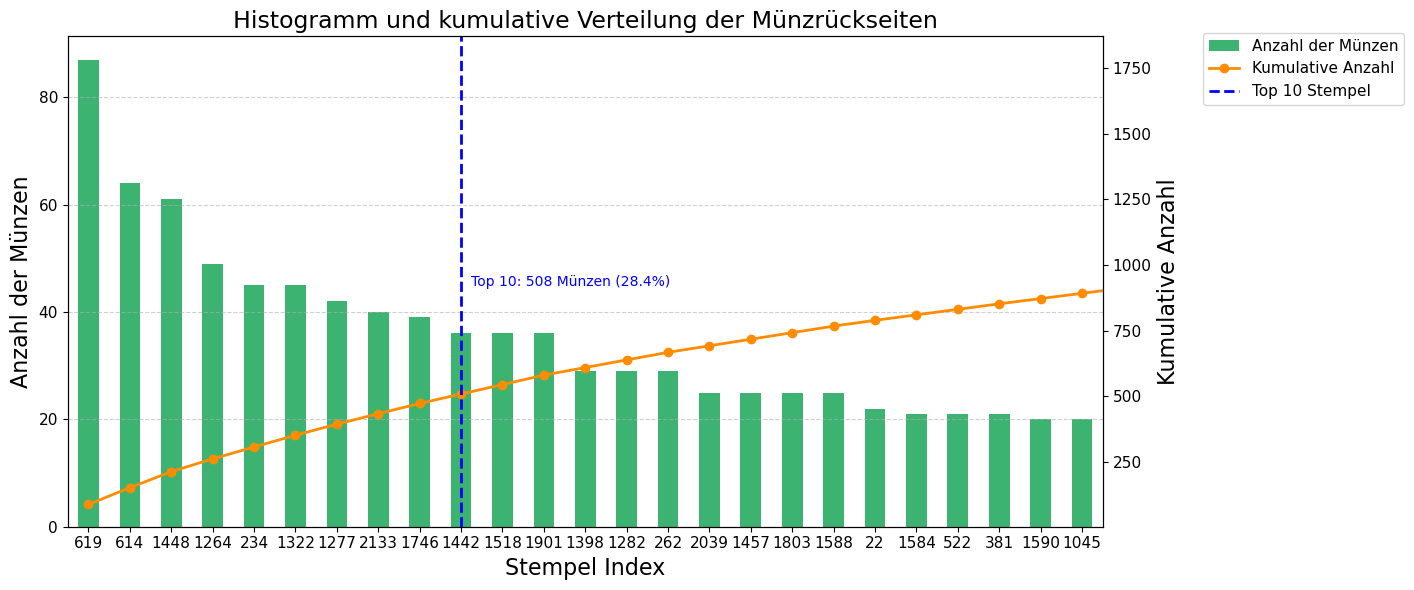

In [92]:
import matplotlib.pyplot as plt
import numpy as np
# Assume these are already defined
# Assume these are already defined
sorted_dice = die_counts.most_common()
dice_labels, counts = zip(*sorted_dice)

x_positions = [i * 2 - 1 for i in range(1, len(dice_labels) + 1)]
cumulative_counts = np.cumsum(counts)
total_count = sum(counts)

# First 10 dies
first_10_coin_count = sum(counts[:10])
threshold_index = 9  # 10th die (index 9)
threshold_x = x_positions[threshold_index]
threshold_y = cumulative_counts[threshold_index]
percentage = 100 * first_10_coin_count / total_count

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot
bar_width = 1.0
bars = ax1.bar(x_positions, counts, width=bar_width, color='mediumseagreen', label='Anzahl der Münzen')
ax1.set_xlabel("Stempel Index")
ax1.set_ylabel("Anzahl der Münzen")
# Set x-axis ticks and labels
ax1.set_xticks(x_positions)
ax1.set_xticklabels(dice_labels)
ax1.set_xlim(0, 50 * bar_width)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Secondary axis for cumulative
ax2 = ax1.twinx()
ax2.plot(x_positions, cumulative_counts, color='darkorange', marker='o', label='Kumulative Anzahl', linewidth=2)
ax2.set_ylabel("Kumulative Anzahl")

# Add vertical line after first 10 dies
ax2.axvline(x=threshold_x, color='blue', linestyle='--', linewidth=2, label='Top 10 Stempel')
ax2.text(threshold_x + 0.5, threshold_y + 400 , f'Top 10: {first_10_coin_count} Münzen ({percentage:.1f}%)',
         color='blue', va='bottom')

# Legends
fig.legend(bbox_to_anchor=(1, 0.95), loc='upper left')
plt.title("Histogramm und kumulative Verteilung der Münzrückseiten")
plt.tight_layout()
plt.savefig("HistogrammKumulativReverseDies2200.png")
#plt.show()


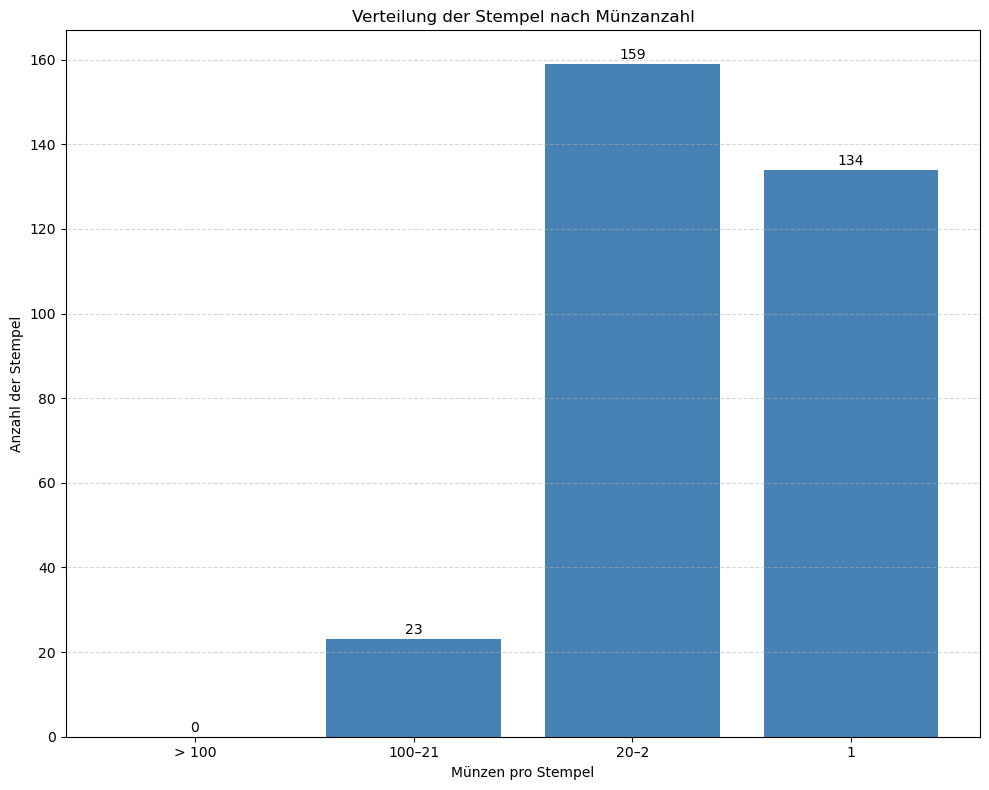

In [6]:
import matplotlib.pyplot as plt

# Extract coin counts per die
sorted_dice = die_counts.most_common()
dice_labels, counts = zip(*sorted_dice)

# Define bins
bin_labels = ['> 100', '100–21', '20–2', '1']
bin_counts = [0, 0, 0, 0]

for count in counts:
    if count > 100:
        bin_counts[0] += 1
    elif count > 20:
        bin_counts[1] += 1
    elif count > 1:
        bin_counts[2] += 1
    else:
        bin_counts[3] += 1

# Plot bar chart
plt.figure(figsize=(10, 8))
bars = plt.bar(bin_labels, bin_counts, color='steelblue')

# Add value labels above bars
for bar, count in zip(bars, bin_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(count), ha='center', va='bottom')

plt.ylabel("Anzahl der Stempel")
plt.xlabel("Münzen pro Stempel")
plt.title("Verteilung der Stempel nach Münzanzahl")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.show()
plt.savefig("VerteilungStempelReverseDies2200.png")

# Filtering Coins out

In [13]:
#print(die_counts[1005])
print("Before Filtering:",len(coin_to_die))
print(coin_to_die)
'''
Filter One time used dies out
filter_coin = [coin for coin in coin_to_die if die_counts[coin["die_index"]] > 1]
print("After Filtering:",len(filter_coin))
df = pd.DataFrame(filter_coin)

# Save to CSV
output_csv = "coin_to_die_reverse_filtered_2200Dies.csv"
df.to_csv(output_csv, index=False)
print(f"Altered version saved to {output_csv}")
'''
#Join One time used dies in a group
die_counts = coin_to_die['die_index'].value_counts()
singleton_dies = die_counts[die_counts == 1].index

# Step 2: Filter rows with singleton die_index
singleton_rows = coin_to_die[coin_to_die['die_index'].isin(singleton_dies)].copy()

# Step 3: Assign a new die_index to all singleton dies
singleton_rows['die_index'] = 'single'  # you can use any name or number

# Step 4: Filter out the singleton dies from original DataFrame
df_remaining = coin_to_die[~coin_to_die['die_index'].isin(singleton_dies)]

# Step 5: Concatenate the modified singleton group back to the main DataFrame
df_final = pd.concat([df_remaining, singleton_rows], ignore_index=True)

output_csv = "coin_to_die_reverse_filtered_2200Dies.csv"
df_final.to_csv(output_csv, index=False)

Before Filtering: 1787
     group  die_index                                         image_path
0     Prot         60  ../bueschelquinare_preprocessed/reverse/Prot/2...
1     Prot        234  ../bueschelquinare_preprocessed/reverse/Prot/3...
2     Prot        619  ../bueschelquinare_preprocessed/reverse/Prot/2...
3     Prot        773  ../bueschelquinare_preprocessed/reverse/Prot/2...
4     Prot       1442  ../bueschelquinare_preprocessed/reverse/Prot/3...
...    ...        ...                                                ...
1782     H       1757  ../bueschelquinare_preprocessed/reverse/H/3980...
1783     H        915  ../bueschelquinare_preprocessed/reverse/H/3930...
1784     G       1310  ../bueschelquinare_preprocessed/reverse/G/182_...
1785     G       1534  ../bueschelquinare_preprocessed/reverse/G/3962...
1786     G       1901  ../bueschelquinare_preprocessed/reverse/G/3275...

[1787 rows x 3 columns]


In [5]:
len(die_counts)

316

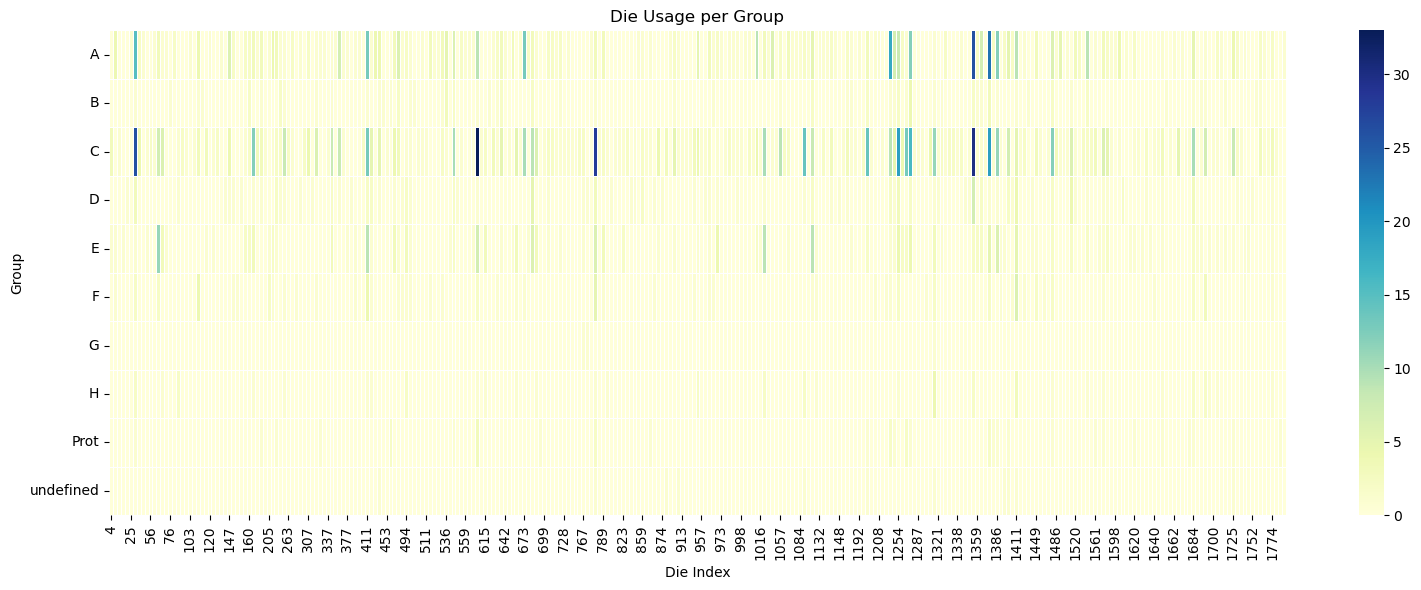

In [182]:
import pandas as pd

# Convert coin_to_die to DataFrame
df = pd.DataFrame(coin_to_die)  # each row should contain 'group' and 'die_index'

# Pivot table: rows = groups, columns = dies, values = count
usage_matrix = df.pivot_table(index="group", columns="die_index", aggfunc="size", fill_value=0)

# Optional: Sort groups if they're chronological (e.g., 'A', 'B', 'C', ...)
usage_matrix = usage_matrix.sort_index()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.heatmap(usage_matrix, cmap="YlGnBu", linewidths=0.5)
plt.title("Die Usage per Group")
plt.xlabel("Die Index")
plt.ylabel("Group")
plt.tight_layout()
plt.show()



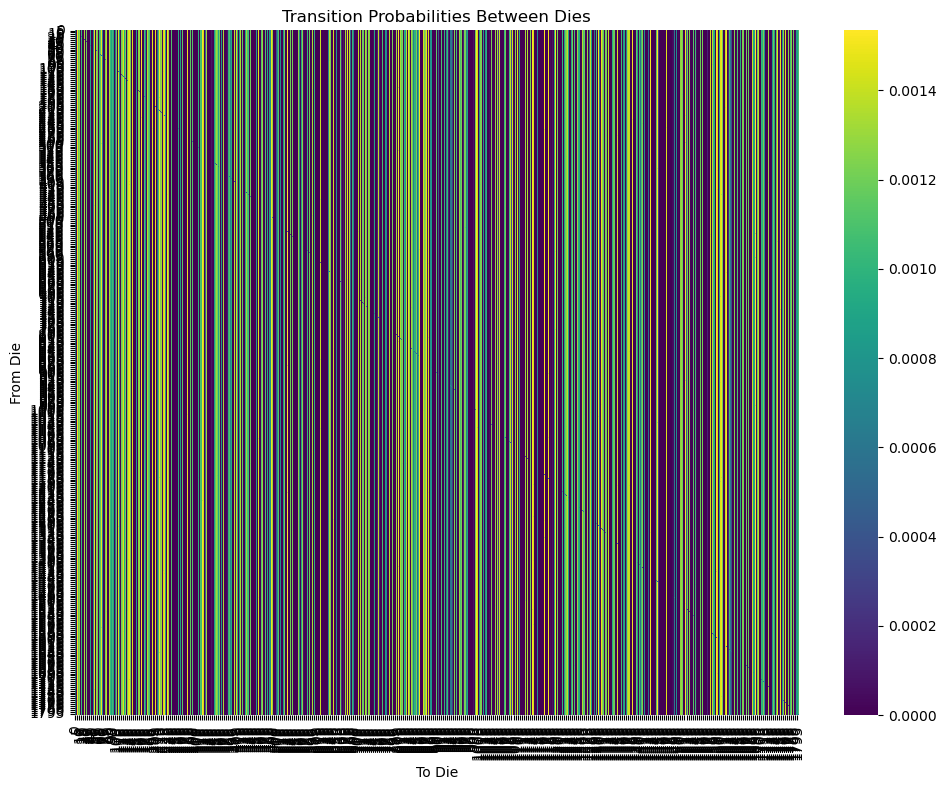

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve learned transition matrix
A_q = pyro.param("A_q").detach().cpu()  # shape: [num_states, num_states]

plt.figure(figsize=(10, 8))
sns.heatmap(A_q, cmap="viridis", xticklabels=5, yticklabels=5)
plt.title("Transition Probabilities Between Dies")
plt.xlabel("To Die")
plt.ylabel("From Die")
plt.tight_layout()
plt.show()


In [23]:
import openpyxl
from openpyxl.drawing.image import Image as OpenpyxlImage
from openpyxl.utils import get_column_letter

# Assuming you already have coin_to_die list of dicts:
# coin_to_die = [
#     {"group": ..., "die_index": ..., "image_path": ...},
#     ...
# ]

# Create workbook and worksheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Coin to Die Data"

# Write header row
headers = ["group", "die_index", "image_path", "image"]
for col_num, header in enumerate(headers, start=1):
    ws.cell(row=1, column=col_num, value=header)

# Starting from second row to write data
for row_num, entry in enumerate(coin_to_die, start=2):
    ws.cell(row=row_num, column=1, value=entry["group"])
    ws.cell(row=row_num, column=2, value=entry["die_index"])
    ws.cell(row=row_num, column=3, value=entry["image_path"])

    # Add image
    try:
        img = OpenpyxlImage(entry["image_path"])

        # Optionally resize images to fit better in cells (adjust as needed)
        max_width = 100  # pixels
        max_height = 100

        # Resize maintaining aspect ratio
        ratio_w = max_width / img.width
        ratio_h = max_height / img.height
        ratio = min(ratio_w, ratio_h, 1)  # Don't upscale images

        img.width = int(img.width * ratio)
        img.height = int(img.height * ratio)

        # Insert image into the 4th column of the current row
        cell_address = f"D{row_num}"
        ws.add_image(img, cell_address)

        # Optionally adjust row height to fit the image
        ws.row_dimensions[row_num].height = img.height * 0.75  # openpyxl uses points

        # Optionally set column width to fit images
        ws.column_dimensions[get_column_letter(4)].width = max_width / 7  # approx width in excel chars

    except FileNotFoundError:
        print(f"Image not found: {entry['image_path']}")
    except Exception as e:
        print(f"Error inserting image for row {row_num}: {e}")

# Save workbook
wb.save("coin_to_die_images_10_features_true_hdp_hsmm__groundtruth_reverse.xlsx")


# Visualization of which die emitted which coin and to which group it belongs

     die_index group  count
0           11     A      3
1           11     C      9
2           11     D      2
5           23     C      4
6           23     E      2
..         ...   ...    ...
492       1199     A      8
493       1199     B      3
494       1199     C     15
495       1199     D      2
496       1199     E      2

[250 rows x 3 columns]


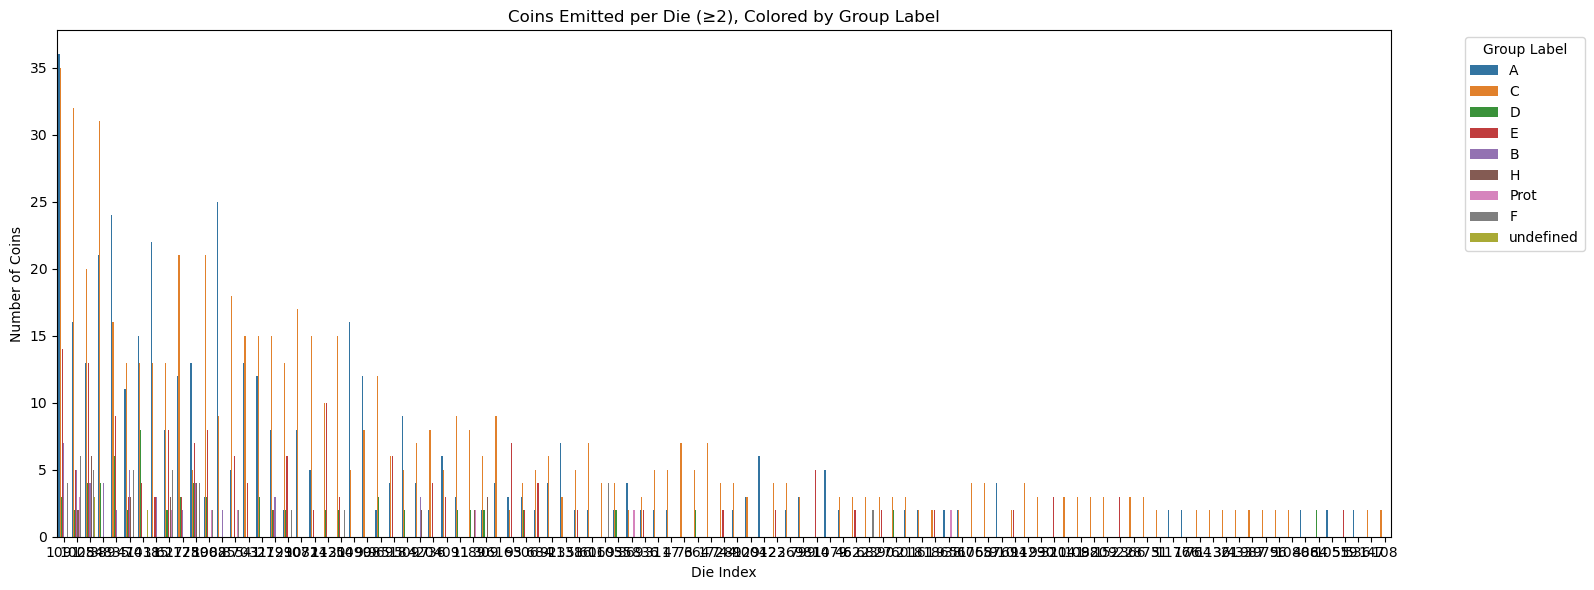

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load assignments
df = pd.read_csv("coin_to_die_reverse_1200Dies.csv")

# Count number of coins emitted per die per group
counts = df.groupby(["die_index", "group"]).size().reset_index(name="count")

# Filter out entries with fewer than 2 coins
counts = counts[counts["count"] >= 2]

print(counts)

# Sort dies by total coins emitted (optional for cleaner plotting)
total_per_die = counts.groupby("die_index")["count"].sum().sort_values(ascending=False)
ordered_dies = total_per_die.index.tolist()
counts["die_index"] = pd.Categorical(counts["die_index"], categories=ordered_dies, ordered=True)

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(data=counts, x="die_index", y="count", hue="group", dodge=True)

plt.title("Coins Emitted per Die (≥2), Colored by Group Label")
plt.xlabel("Die Index")
plt.ylabel("Number of Coins")
# plt.yscale("log")  # Optional if you want log scale
plt.legend(title="Group Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# False-Positive Rate for training sets

In [84]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

mpl.rcParams.update({
    "axes.titlesize":17,
    "axes.labelsize":16,
    "xtick.labelsize":11,
    "ytick.labelsize":11,
    "legend.fontsize": 11})

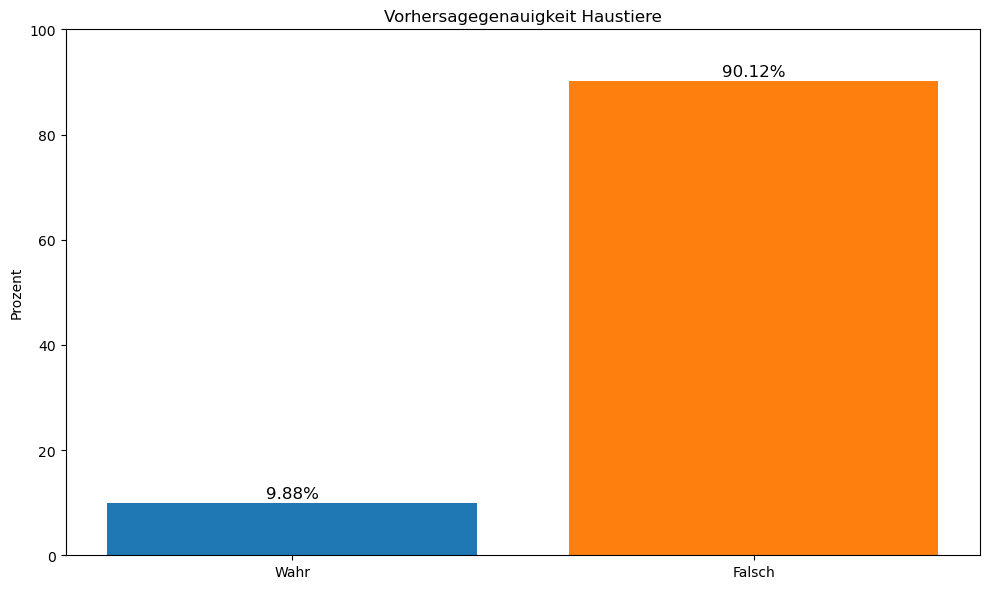

In [16]:
df = pd.read_csv("numbers_assignment.csv")
#df['image_path'] = df['image_path'].str.extract(r'/[A-Za-z]+/([a-z]+)_preprocessed')
# Calculate TP and FN for each class
TP = {}
FN = {}

for i in range(10):
    TP[i] = ((df["die_index"] == i) & (df["image_path"] == i)).sum()
    FN[i] = ((df["die_index"] == i) & (df["image_path"] != i)).sum()
'''
TP[0] = ((df["die_index"] == 0) & (df["image_path"] == "cat")).sum()
FN[0] = ((df["die_index"] == 0) & (df["image_path"] == "dog")).sum()
TP[1] = ((df["die_index"] == 1) & (df["image_path"] == "dog")).sum()
FN[1] = ((df["die_index"] == 1) & (df["image_path"] == "cat")).sum()
'''
# Total predictions
total_correct = sum(TP.values())
total_incorrect = sum(FN.values())
Total = total_correct + total_incorrect

# Plot
labels = ["Wahr", "Falsch"]
values = [total_correct / Total * 100, total_incorrect / Total * 100]  # percent
colors = ["#1f77b4", "#ff7f0e"]  # Blue and orange

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{height:.2f}%",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylim(0, 100)
plt.ylabel("Prozent")

plt.title("Vorhersagegenauigkeit Haustiere")
plt.tight_layout()
plt.show()






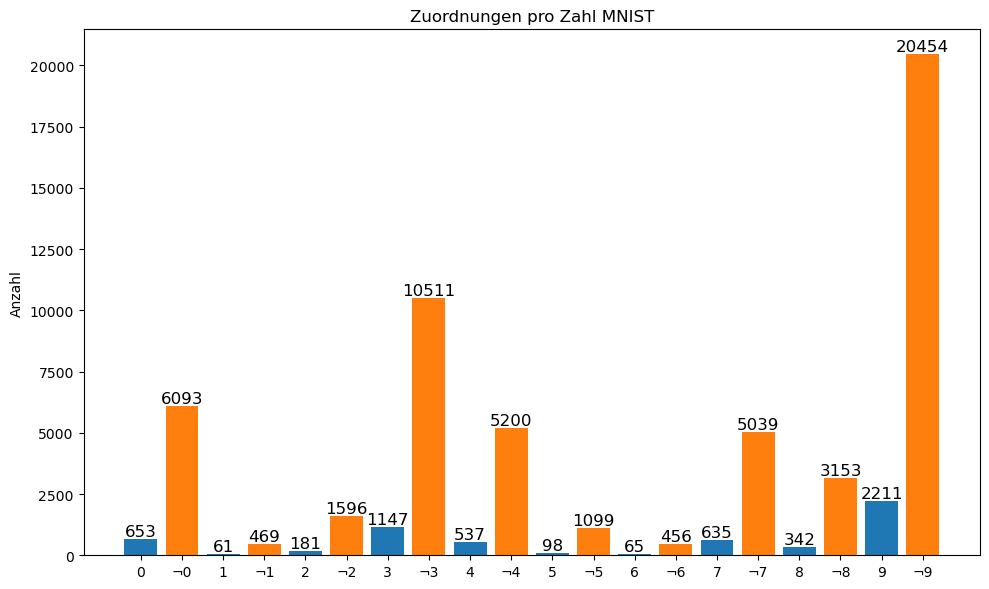

In [17]:


# Create labels and values
#labels = ["Katze","Keine Katze","Hund","Kein Hund"]
values = []
labels = []
for i in range(10):
    labels.extend([f"{i}", f"\u00AC{i}"])  # Correct, Incorrect
    values.extend([TP[i], FN[i]])

# Alternate colors: blue for TP, orange for FN
colors = ['#1f77b4' if i % 2 == 0 else '#ff7f0e' for i in range(len(values))]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{height}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.ylabel("Anzahl")

plt.title("Zuordnungen pro Zahl MNIST")
plt.tight_layout()
plt.savefig("ZuordnungenMNIST.png")


# Sankey Diagramm

In [269]:
import pandas as pd
import plotly.graph_objects as go

groundtruth = pd.read_excel("../Stempelliste_bueschel_Neuses_einfach.xlsx", engine='openpyxl')
obverse = pd.read_csv("coin_die_assignments_reverse.csv")
groundtruth["Stempeluntergruppe Rv"] = groundtruth["Stempeluntergruppe Rv"].fillna("Unknown")
groundtruth["ID"] = groundtruth["Dédalo ID"]
obverse["ID"] = obverse["image_path"].str.extract(r'/(\d+)[^/]*$')[0].astype("Int64")

# Merge based on ID
merged_df = pd.merge(obverse, groundtruth, on="ID")

# Count flows
flow_df = merged_df.groupby(["Stempeluntergruppe Rv", "die_index"]).size().reset_index(name="count")

# All unique labels (source + target)
all_labels = pd.unique(flow_df[["Stempeluntergruppe Rv", "die_index"]].values.ravel())

# Map labels to indices
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Assign source and target indices
flow_df["source"] = flow_df["Stempeluntergruppe Rv"].map(label_to_index)
flow_df["target"] = flow_df["die_index"].map(label_to_index)

# Calculate totals per die_index (targets)
target_totals = flow_df.groupby("die_index")["count"].sum().to_dict()

# Build final labels with counts appended for target nodes
final_labels = []
for label in all_labels:
    if label in target_totals:
        final_labels.append(f"{label} ({target_totals[label]})")
    else:
        final_labels.append(label)

# Re-map source and target because label indices changed by final_labels order
final_label_to_index = {label: i for i, label in enumerate(all_labels)}  # same order, no change here

# Build Sankey figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=final_labels
    ),
    link=dict(
        source=flow_df["source"],
        target=flow_df["target"],
        value=flow_df["count"]
    ))])

fig.update_layout(
    title_text="Groundtruth to Your Dies Mapping (with counts)",
    font_size=12,
    width=1900,
    height=1200
)
#fig.show()
fig.write_html("GroundTruth_Reverse80Dies.html")
